<h2>Thông tin chung về dữ liệu</h2>

In [1]:
#Import các thư viện cần thiết
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col, when, count, desc
import pyspark.sql.functions as F
from pyspark.sql.functions import round as spark_round

In [2]:
#Sử dụng biến SparkSession để đọc dữ liệu đầu vào từ tập tin csv.
spark = SparkSession.builder.appName("BigData").getOrCreate()
data = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("Preprocessed1.csv")
data.cache()

24/06/03 22:25:46 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


DataFrame[Num_of_reviews: double, General_rate: double, Comfort: double, Interior design: double, Performance: double, Value for the money: double, Exterior styling: double, Reliability: double, Year: int, Brand: string, Model: string, Brand_encoded: double, Model_encoded: double, Year_encoded: double]

In [3]:
data1 = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("Car_Rates.csv")
data1.cache()

DataFrame[Car_name: string, Num_of_reviews: double, General_rate: double, Comfort: double, Interior design: double, Performance: double, Value for the money: double, Exterior styling: double, Reliability: double, Year: int, Brand: string, Model: string]

In [4]:
# Tính giá trị trung bình của các cột số và điền vào các giá trị bị thiếu
numerical_columns = ["Num_of_reviews", "General_rate", "Comfort", "Interior design", "Performance", "Value for the money", "Exterior styling", "Reliability"]
means = data1.agg(*[mean(c).alias(c) for c in numerical_columns])

# Tạo một dictionary chứa các giá trị trung bình
means_dict = means.first().asDict()

# Điền các giá trị bị thiếu bằng giá trị trung bình tương ứng
data1 = data1.na.fill(means_dict)

# Định nghĩa hàm làm tròn đến 3 chữ số sau dấu phẩy
def round_to_3(x):
    return spark_round(x, 3)

for col_name in numerical_columns:
    data1 = data1.withColumn(col_name, round_to_3(col(col_name)))

In [5]:
train_data1, test_data1 = data1.randomSplit([0.8, 0.2], seed=42)
actualsor = test_data1.select('General_rate').rdd.flatMap(lambda x: x).collect()

In [6]:
#Đếm số dòng
rows = data.count()
print(f"Number of rows: {rows}")

#Đếm số cột
cols = len(data.columns)
print(f"Number of columns: {cols}")

Number of rows: 4243
Number of columns: 14


In [7]:
#Hiển thị schema dữ liệu
data.printSchema()

root
 |-- Num_of_reviews: double (nullable = true)
 |-- General_rate: double (nullable = true)
 |-- Comfort: double (nullable = true)
 |-- Interior design: double (nullable = true)
 |-- Performance: double (nullable = true)
 |-- Value for the money: double (nullable = true)
 |-- Exterior styling: double (nullable = true)
 |-- Reliability: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Brand_encoded: double (nullable = true)
 |-- Model_encoded: double (nullable = true)
 |-- Year_encoded: double (nullable = true)



In [8]:
data = data.drop("Car_name")
data = data.drop("Year")
data = data.drop("Brand")
data = data.drop("Model")

In [9]:
data.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------------+
|      Num_of_reviews|        General_rate|             Comfort|     Interior design|         Performance| Value for the money|    Exterior styling|         Reliability|     Brand_encoded|       Model_encoded|       Year_encoded|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------------+
| -0.6123491603209582|-0.08643390285902246| -0.7545263019492695| -0.6743031993284665|-0.04391996296542...| -0.6851534523856326|  0.9646959446827771|  0.4318711620748949|0.5762989879981522| 0.19398712739540971|-0.9975666263770457|
|6.967828264214372...|1.252723235112115...|-1.84051140108654...|-3.7138241311318

In [10]:
data_indexed = data.select([col(c).alias(c) for c in data.columns if c != 'General_rate'] + ['General_rate'])

In [11]:
# Chia tập dữ liệu thành tập huấn luyện và kiểm tra
train_data, test_data = data_indexed.randomSplit([0.8, 0.2], seed=42)


In [12]:
train_data.printSchema()

root
 |-- Num_of_reviews: double (nullable = true)
 |-- Comfort: double (nullable = true)
 |-- Interior design: double (nullable = true)
 |-- Performance: double (nullable = true)
 |-- Value for the money: double (nullable = true)
 |-- Exterior styling: double (nullable = true)
 |-- Reliability: double (nullable = true)
 |-- Brand_encoded: double (nullable = true)
 |-- Model_encoded: double (nullable = true)
 |-- Year_encoded: double (nullable = true)
 |-- General_rate: double (nullable = true)



In [13]:
train_data.show()

+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|     Num_of_reviews|            Comfort|    Interior design|        Performance|Value for the money|   Exterior styling|         Reliability|       Brand_encoded|       Model_encoded|       Year_encoded|        General_rate|
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|-0.6607755627504296|-10.819651289219026|-10.829117790130173| -9.502351792221543| -8.538502263839833|-12.729203468792113|  -9.185896854241669| -0.9336081928782111| -0.7163587658606708| 0.4339387834301124| -11.626405505959832|
|-0.6607755627504296|-10.819651289219026|-10.829117790130173| -9.502351792221543| -8.53850226383

In [14]:
import sys
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

def XTX(row):
    #Xử lý đầu vào: Hàm nhận một hàng giá trị làm đầu vào.
    value_X= np.array(row[1:], dtype='float')
    #Tạo ma trận: Mảng value_X sau đó được chuyển đổi thành một ma trận X bằng cách chèn một cột của số 1 vào đầu
    matX = np.matrix(value_X)
    X = np.insert(matX, 0, 1, axis=1)
    #Tính toán ma trận chuyển vị: Hàm này thực hiện phép chuyển vị trên ma trận X
    transpose_X = X.T 
    #Tính toán tích của ma trận chuyển vị với chính nó: 
    #Sau đó, hàm tính tích của ma trận chuyển vị transpose_X với chính nó, tạo ra ma trận kết quả XTX
    XTX = np.dot(transpose_X, X)
    return XTX

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
def XTY(row):
    #Xử lý đầu vào: Hàm nhận một hàng giá trị làm đầu vào
    value_X = np.array(row[1:-1], dtype='float')
    #Trừ cột cuối cùng, được coi là giá trị mục tiêu (hoặc kết quả) của mô hình.
    value_Y = row[-1]
    #Tạo ma trận: Mảng value_X sau đó được chuyển đổi thành một ma trận X bằng cách chèn một cột của số 1 vào đầu
    matX = np.matrix(value_X)
    X = np.insert(matX, 0, 1, axis=1)
    #Tính toán ma trận chuyển vị của X: Hàm này thực hiện phép chuyển vị trên ma trận X
    transpose_X = X.T
    #Tạo ma trận Y: Giá trị đầu vào cuối cùng của hàng (được lấy từ row[-1]) được sử dụng làm giá trị của vector cột Y
    Y = np.matrix([value_Y])
    #Tính toán tích của ma trận chuyển vị X với Y: Hàm tính tích của ma trận chuyển vị transpose_X với vector cột Y,
    XTY = np.dot(transpose_X,Y)
    #Trả về kết quả: Kết quả cuối cùng là ma trận XTY, chứa các giá trị tích của ma trận chuyển vị X với vector cột Y
    return XTY    

In [16]:
from pyspark.sql.functions import lit

train_data1 = train_data.withColumn("intercept", lit(1.0))
selected_data = train_data1.select("intercept", train_data.columns[0], train_data.columns[1], train_data.columns[2], train_data.columns[3], train_data.columns[4], train_data.columns[5], train_data.columns[6], train_data.columns[7], train_data.columns[8], train_data.columns[9], train_data.columns[10])
selected_data2 = selected_data.drop("General_rate")

In [17]:
selected_data.show()

+---------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|intercept|     Num_of_reviews|            Comfort|    Interior design|        Performance|Value for the money|   Exterior styling|         Reliability|       Brand_encoded|       Model_encoded|       Year_encoded|        General_rate|
+---------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|      1.0|-0.6607755627504296|-10.819651289219026|-10.829117790130173| -9.502351792221543| -8.538502263839833|-12.729203468792113|  -9.185896854241669| -0.9336081928782111| -0.7163587658606708| 0.4339387834301124| -11.626405505959832|
|      1.0|-0.6607755627504296|-10.819651289219026|-10.8

In [18]:
selected_data2.show()

+---------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|intercept|     Num_of_reviews|            Comfort|    Interior design|        Performance|Value for the money|   Exterior styling|         Reliability|       Brand_encoded|       Model_encoded|       Year_encoded|
+---------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|      1.0|-0.6607755627504296|-10.819651289219026|-10.829117790130173| -9.502351792221543| -8.538502263839833|-12.729203468792113|  -9.185896854241669| -0.9336081928782111| -0.7163587658606708| 0.4339387834301124|
|      1.0|-0.6607755627504296|-10.819651289219026|-10.829117790130173| -9.502351792221543| -8.538502263839833|-12.729203468792113|  -9.1858

In [19]:
# Tinh X^T*X
XTX = np.array(selected_data2.rdd.map(XTX).reduce(lambda a, b: np.add(a, b)))
inverseXTX = np.linalg.inv(XTX)
# Tinh X^T*Y
XTY = np.array(selected_data.rdd.map(XTY).reduce(lambda a, b: np.add(a, b)))
# Ket qua
beta = np.dot(inverseXTX, XTY)
print("beta: ")
for coeff in beta:
    print(coeff)

beta: 
[-0.0001889]
[-0.00301309]
[0.17346495]
[0.17405569]
[0.23374433]
[0.2226173]
[0.14654116]
[0.21685411]
[0.00085288]
[0.00048487]
[2.28417833e-05]


In [21]:
dataf = test_data.drop("General_rate")
rdd = dataf.rdd
# Khởi tạo mảng kết quả trống
results = []
for row in rdd.collect():
    Num_of_reviews_index = row["Num_of_reviews"]
    Comfort_index = row["Comfort"]
    Interior_design_index = row["Interior design"]
    Performance_index = row["Performance"]
    Value_for_the_money_index = row["Value for the money"]
    Exterior_styling_index = row["Exterior styling"]
    Reliability_index = row["Reliability"]    
    Brand_encoded_index = row["Brand_encoded"]
    Model_encoded_index = row["Model_encoded"]
    Year_encoded_index = row["Year_encoded"]
    result = (
        beta[0] +
        beta[1] * Num_of_reviews_index +
        beta[2] * Comfort_index +
        beta[3] * Interior_design_index +
        beta[4] * Performance_index +
        beta[5] * Value_for_the_money_index +
        beta[6] * Exterior_styling_index +
        beta[7] * Reliability_index +
        beta[8] * Brand_encoded_index +
        beta[9] * Model_encoded_index +
        beta[10] * Year_encoded_index 
    )
    # Thêm kết quả tính toán vào mảng kết quả
    results.append(result)
    print("Result:", result)

resultss = []

# Lặp qua từng mảng trong danh sách results và trích xuất giá trị đầu tiên từ mỗi mảng
for arr in results:
    resultss.append(arr[0])

Result: [-11.73922816]
Result: [-6.04833668]
Result: [-6.34385606]
Result: [-2.5182935]
Result: [-2.55179801]
Result: [-1.43775912]
Result: [0.20611991]
Result: [0.11074029]
Result: [0.17811899]
Result: [0.17703964]
Result: [0.52172477]
Result: [0.72445326]
Result: [-1.57714854]
Result: [-0.99130079]
Result: [0.17113153]
Result: [0.71790966]
Result: [0.07822754]
Result: [0.69096075]
Result: [0.69222705]
Result: [0.69355211]
Result: [0.18708733]
Result: [0.73477963]
Result: [0.69076772]
Result: [1.03496842]
Result: [1.23656984]
Result: [1.23736472]
Result: [1.23713525]
Result: [1.23772717]
Result: [1.2376159]
Result: [1.23816376]
Result: [1.23785902]
Result: [1.2384974]
Result: [1.23909206]
Result: [1.23904973]
Result: [1.23900389]
Result: [1.24047407]
Result: [-2.54502918]
Result: [-1.94564254]
Result: [-1.9431946]
Result: [-1.76494525]
Result: [-2.61733781]
Result: [-1.79668174]
Result: [-1.49846536]
Result: [-0.39329326]
Result: [-3.19682072]
Result: [-1.49021912]
Result: [-0.9297445

In [22]:
def calculate_mean_std(data):
  if len(data) == 0:
    return 0, 0

  mean = sum(data) / len(data)
  squared_differences = [abs(value - mean)**2 for value in data]
  variance = sum(squared_differences) / len(data)
  std = variance**0.5
  return mean, std


In [23]:
def convert_to_original(data, mean, std):
  original_values = np.array(data) * std + mean
  return original_values

In [ ]:
from math import sqrt  # Import sqrt for RMSE calculation
actuals = test_data.select('General_rate').rdd.flatMap(lambda x: x).collect()
def calculate_metrics(p_data, data):
  predictions = p_data
  actuals = data

  # Tính RMSE (Calculate RMSE)
  mse = sum([(p - a) ** 2 for p, a in zip(predictions, actuals)]) / len(actuals)
  rmse = sqrt(mse)

  # Tính MAE (Calculate MAE)
  mae = sum([abs(p - a) for p, a in zip(predictions, actuals)]) / len(actuals)

  # Tính MAPE (Calculate MAPE)
  #mape = sum([abs((p - a) / a) for p, a in zip(predictions, actuals) if a != 0]) / (len([a for a in actuals if a != 0])) * 100
  mean_actuals = sum(actuals) / len(actuals)
  total_sum_of_squares = sum((a - mean_actuals) ** 2 for a in actuals)
  residual_sum_of_squares = sum((p - a) ** 2 for p, a in zip(predictions, actuals))
    
  r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)

  return rmse, mae, r_squared

# Usage example:
mean, std = calculate_mean_std(actualsor)
original_values = convert_to_original(actuals, mean, std)
original_values_results = convert_to_original(resultss, mean, std)
rmse, mae, r_squared = calculate_metrics(original_values_results, original_values)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r_squared}")

/home/bz/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


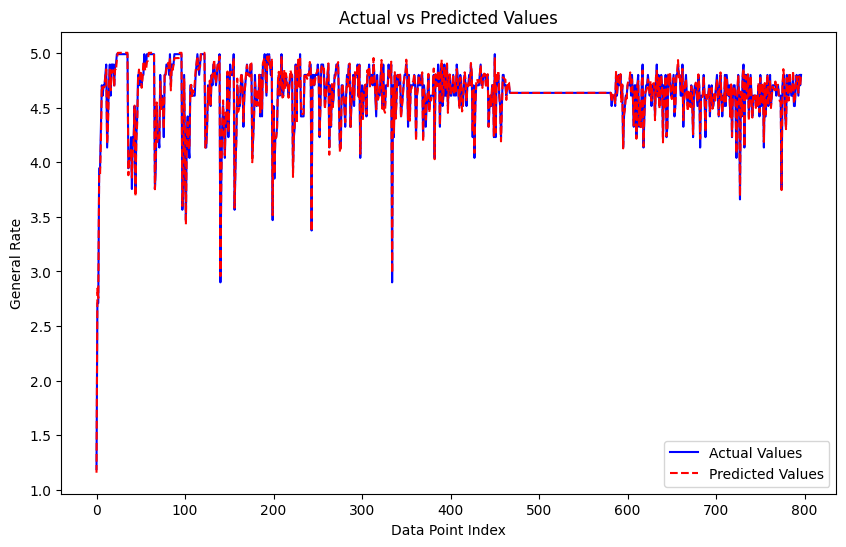

In [25]:
#visual
import matplotlib.pyplot as plt
# Trực quan hóa kết quả
plt.figure(figsize=(10, 6))
plt.plot(original_values, label='Actual Values', color='b')
plt.plot(original_values_results, label='Predicted Values', color='r', linestyle='--')
plt.xlabel('Data Point Index')
plt.ylabel('General Rate')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [26]:
# Stop SparkSession
spark.stop()

In [27]:
original_values_results

array([1.15729582, 2.84296963, 2.75543514, 3.88858812, 3.8786639 ,
       4.20864843, 4.69557457, 4.66732259, 4.68728054, 4.68696083,
       4.78905849, 4.8491078 , 4.16736051, 4.34089188, 4.68521082,
       4.84716955, 4.65769214, 4.83918713, 4.83956222, 4.83995471,
       4.68993701, 4.85216653, 4.83912995, 4.94108412, 5.00079959,
       5.00103504, 5.00096707, 5.0011424 , 5.00110944, 5.00127172,
       5.00118145, 5.00137054, 5.00154668, 5.00153415, 5.00152057,
       5.00195604, 3.88066886, 4.05821053, 4.05893562, 4.11173407,
       3.85925064, 4.10233355, 4.1906669 , 4.51802505, 3.68760457,
       4.19310949, 4.35912519, 4.76775688, 4.84771128, 4.7632876 ,
       4.83287248, 4.68107893, 4.76940575, 4.92425052, 4.90995759,
       4.83937111, 4.84602474, 4.92018903, 4.92690846, 5.00100361,
       5.00109967, 5.00110701, 5.00123592, 5.0015577 , 5.0015258 ,
       5.00138528, 3.75223826, 4.04664992, 4.54683871, 4.18579248,
       4.19728845, 4.20100904, 4.73855647, 4.46768973, 4.58202

In [28]:
original_values

array([1.19071453, 2.70991629, 2.70991629, 3.94426773, 3.94426773,
       4.32406817, 4.70386861, 4.6089185 , 4.70386861, 4.70386861,
       4.79881872, 4.89376883, 4.13416795, 4.41901828, 4.70386861,
       4.89376883, 4.6089185 , 4.89376883, 4.89376883, 4.89376883,
       4.70386861, 4.89376883, 4.89376883, 4.98871894, 4.98871894,
       4.98871894, 4.98871894, 4.98871894, 4.98871894, 4.98871894,
       4.98871894, 4.98871894, 4.98871894, 4.98871894, 4.98871894,
       4.98871894, 3.94426773, 4.03921784, 4.03921784, 4.22911806,
       3.75436751, 4.22911806, 4.22911806, 4.51396839, 3.75436751,
       4.22911806, 4.41901828, 4.79881872, 4.79881872, 4.70386861,
       4.79881872, 4.70386861, 4.79881872, 4.79881872, 4.98871894,
       4.89376883, 4.89376883, 4.98871894, 4.98871894, 4.98871894,
       4.98871894, 4.98871894, 4.98871894, 4.98871894, 4.98871894,
       4.98871894, 3.75436751, 3.94426773, 4.51396839, 4.22911806,
       4.22911806, 4.13416795, 4.79881872, 4.51396839, 4.60891